In [1]:
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras import *
import numpy as np
import os
from PIL import Image as pillow
import matplotlib.pyplot as plt
import glob
import copy

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
for physical_device in physical_devices: 
    tf.config.experimental.set_memory_growth(physical_device, True)

In [3]:
path_list = glob.glob('C:/Users/qwopq/Downloads/img_align_celeba/img_align_celeba/*')
train_x = []
for i in range(len(path_list[:10000])):
    train_x.append(np.array(pillow.open(path_list[i]).convert('RGB').resize((128,128)),'float32'))
    if i%10000 == 0:
        print(i)
train_x = np.array(train_x,'float32')

0


In [4]:
filters = 64

In [5]:
def RB(x,filters):
    skip = x
    x = layers.Conv2D(filters,3,padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(filters,3,padding='same')(x)
    x = x + skip
    return x

def CA(x,filters):
    skip = x
    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dense(filters/4)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dense(filters)(x)
    x = activations.sigmoid(x)
    x = layers.Reshape((1,1,filters))(x)
    x = x * skip
    return x

def NTB(x,filters):
    skip = x
    x = RB(x,filters)
    x = RB(x,filters)
    x = CA(x,filters)
    x = RB(x,filters)
    x = RB(x,filters)
    x = CA(x,filters)
    x = x + skip
    return x

input_x = layers.Input((None,None,3))
x = layers.Conv2D(filters,3,padding='same')(input_x)
x = layers.LeakyReLU()(x)
skip = x
x = NTB(x,filters)
x = NTB(x,filters)
x = NTB(x,filters)
x = NTB(x,filters)
x = x + skip
x = layers.Conv2D(filters,3,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(3,3,padding='same')(x)
x = input_x + x
gan = Model(input_x,x)

In [6]:
def conv_block(x,filters):
    x = layers.Conv2D(filters,3,padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    return x

input_x = layers.Input((None,None,3),dtype='float16')
x = conv_block(input_x,filters)
x = conv_block(x,filters)
x = layers.MaxPool2D(2)(x)
x = conv_block(x,filters*2)
x = conv_block(x,filters*2)
x = layers.MaxPool2D(2)(x)
x = conv_block(x,filters*4)
x = conv_block(x,filters*4)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(100)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dense(1)(x)
dis_g = Model(input_x,x)

input_x = layers.Input((None,None,3),dtype='float16')
x = conv_block(input_x,filters)
x = conv_block(x,filters)
x = layers.MaxPool2D(2)(x)
x = conv_block(x,filters*2)
x = layers.MaxPool2D(2)(x)
x = conv_block(x,filters*2)
x = layers.MaxPool2D(2)(x)
x = conv_block(x,filters*4)
x = layers.MaxPool2D(2)(x)
x = conv_block(x,filters*4)
x = layers.MaxPool2D(2)(x)
x = conv_block(x,filters*8)
x = conv_block(x,1)
dis_l = Model(input_x,x)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [7]:
optimizer = optimizers.Adam(0.0002, 0.5)

In [8]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [9]:
def generator_loss(disc_generated_output_l,disc_generated_output_g, gen_output, target):
    gan_loss_l = losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_generated_output_l), disc_generated_output_l)
    gan_loss_g = losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_generated_output_g), disc_generated_output_g)
    gan_loss = gan_loss_l + gan_loss_g
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = 0.01*gan_loss + l1_loss
    return total_gen_loss, gan_loss, l1_loss

In [10]:
@tf.function
def train_step(input_image,target):
    with tf.GradientTape() as gan_tape, tf.GradientTape() as dis_tape_l, tf.GradientTape() as dis_tape_g:
        gen_output = gan(input_image, training=True)
        
        disc_real_output_l = dis_l(target, training=True)
        disc_generated_output_l = dis_l(gen_output, training=True)
        
        disc_real_output_g = dis_g(target, training=True)
        disc_generated_output_g = dis_g(gen_output, training=True)
        
        gen_total_loss = generator_loss(disc_generated_output_l,disc_generated_output_g, gen_output, target)
        disc_loss_l = discriminator_loss(disc_real_output_l, disc_generated_output_l)
        disc_loss_g = discriminator_loss(disc_real_output_g, disc_generated_output_g)
        
    generator_gradients = gan_tape.gradient(gen_total_loss,gan.trainable_variables)
    discriminator_gradients_l = dis_tape_l.gradient(disc_loss_l,dis_l.trainable_variables)
    discriminator_gradients_g = dis_tape_g.gradient(disc_loss_g,dis_g.trainable_variables)

    optimizer.apply_gradients(zip(generator_gradients,gan.trainable_variables))
    optimizer.apply_gradients(zip(discriminator_gradients_l,dis_l.trainable_variables))
    optimizer.apply_gradients(zip(discriminator_gradients_g,dis_g.trainable_variables))

In [11]:
def fit(train_x,step,batch_size):
    for i in range(step):
        idx = np.random.randint(0,train_x.shape[0]-batch_size)
        x = copy.deepcopy(np.array(train_x[idx:idx+batch_size]))
        input_image = np.zeros((x.shape[0],x.shape[1],x.shape[2],3),'float32')
        for j in range(x.shape[0]):
            img  = tf.image.random_jpeg_quality(tf.cast(x[j],'uint8'),20,21)
            input_image[j] = img
        input_image = np.array(input_image,'float32')
        train_step((input_image/255),(x/255))
        if i%100 == 0:
            print(i)

In [12]:
fit(train_x,5000,4)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [13]:
test_img = copy.deepcopy(train_x[1])

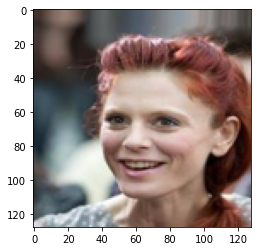

In [14]:
plt.imshow(np.array(test_img,'uint8'))

In [15]:
test_img = tf.image.random_jpeg_quality(tf.cast(test_img,'uint8'),20,21)

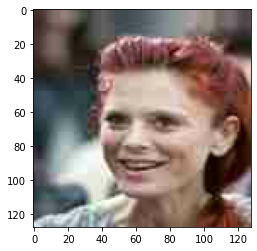

In [16]:
plt.imshow(np.array(test_img,'uint8'))

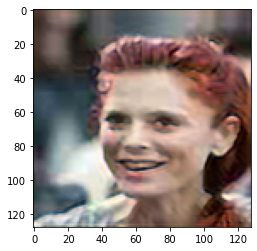

In [17]:
plt.imshow(np.array(np.clip((gan(np.array(test_img[tf.newaxis],'float32')/255)*255),0,255)[0],'uint8'))